In [260]:
import geopandas as gpd

sgb = gpd.read_file('swm-droogtetools//shp//stroomgebied.shp')
sgb = sgb.to_crs(epsg=4326)
minx = sgb.geometry.bounds.minx[0]
maxx = sgb.geometry.bounds.maxx[0]
miny = sgb.geometry.bounds.miny[0]
maxy = sgb.geometry.bounds.maxy[0]

S:\WinPython 3.8\python-3.8.1.amd64\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [261]:
import requests
url = 'http://10.10.3.126:8080/KiWIS/KiWIS?service=kisters&type=queryServices&request=getStationList&datasource=0&format=geojson&bbox={},{},{},{}'.format(minx, miny, maxx, maxy)
r = requests.get(url)
points = gpd.GeoDataFrame.from_features(r.json())

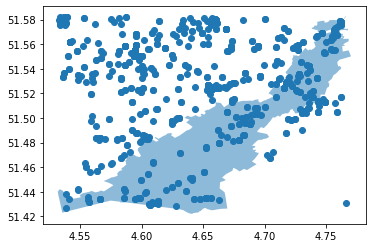

In [262]:
ax = points.plot()
sgb.plot(alpha=0.5, ax=ax)

In [263]:
points = points[points.within(sgb.geometry[0])] # select points within sgb

In [264]:
points[points.station_no.str.contains('4501')]

geometry   station_name    station_no station_id  \
0    POINT (4.75685 51.57175)  !Bovenstrooms  4501_WTH_BOV      13180   
708  POINT (4.75685 51.57175)   Totaaldebiet      4501_TDB      13179   
782  POINT (4.75685 51.57175)    Waterhoogte      4501_WTH      13178   

     station_latitude  station_longitude  
0           51.571751            4.75685  
708         51.571751            4.75685  
782         51.571751            4.75685

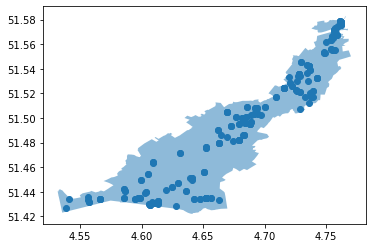

In [265]:
ax = points.plot()
sgb.plot(alpha=0.5, ax=ax)

In [266]:
url = 'http://10.10.3.126:8080/KiWIS/KiWIS?service=kisters&type=queryServices&request=getTimeseriesList&datasource=0&format=json&ts_name=Dag.Gem&returnfields=station_no,ts_id'
r = requests.get(url)

In [267]:
import pandas as pd
ts_ids = pd.DataFrame(r.json()[1:], columns=r.json()[0])

In [268]:
ts_ids[ts_ids.station_no.str.contains('4501')]

station_no    ts_id
107       4501_TDB  7889042
1095      4501_TDB  7882042
3060  4501_WTH_BOV  7896042
3528      4501_WTH  7874042

In [269]:
points = points.merge(ts_ids, left_on='station_no', right_on='station_no') # merge ts_id

In [270]:
points[points.station_no.str.contains('4501')]

geometry   station_name    station_no station_id  \
0   POINT (4.75685 51.57175)  !Bovenstrooms  4501_WTH_BOV      13180   
70  POINT (4.75685 51.57175)   Totaaldebiet      4501_TDB      13179   
71  POINT (4.75685 51.57175)   Totaaldebiet      4501_TDB      13179   
87  POINT (4.75685 51.57175)    Waterhoogte      4501_WTH      13178   

    station_latitude  station_longitude    ts_id  
0          51.571751            4.75685  7896042  
70         51.571751            4.75685  7889042  
71         51.571751            4.75685  7882042  
87         51.571751            4.75685  7874042

In [280]:
import io
mtpnt = pd.DataFrame()
for (i, ts_id), station_no in zip(enumerate(points.ts_id.to_list()), points.station_no.to_list()):
    try:
        url = 'http://10.10.3.126:8080/KiWIS/KiWIS?service=kisters&type=queryServices&request=getTimeseriesValues&datasource=0&format=csv&ts_id={}&period=complete'.format(ts_id)
        r = requests.get(url)
        t = pd.read_csv(io.StringIO(r.text), sep=';', skiprows=3, parse_dates=['dates'], index_col=['dates'], names=['dates', station_no])
        t.index = t.index.tz_localize(None)
        mtpnt = pd.concat([mtpnt, t], axis=1)
    except:
        print(station_no)

3027_PBF
3029_PBF
            4501_TDB
dates               
1982-01-01    15.204
1982-01-02    10.802
1982-01-03    17.489
1982-01-04     9.648
1982-01-05    14.913
            4501_WTH_BOV  4254_WTH_BEN  4253_WTH_BEN  4265_WTH_BEN  \
dates                                                                
1976-01-01         0.741           NaN           NaN           NaN   
1976-01-02         0.859           NaN           NaN           NaN   
1976-01-03         0.832           NaN           NaN           NaN   
1976-01-04         0.771           NaN           NaN           NaN   
1976-01-05         0.776           NaN           NaN           NaN   

            4256_WTH_BEN  4255_WTH_BEN  4252_WTH_BEN  4251_WTH_BEN  \
dates                                                                
1976-01-01           NaN           NaN           NaN           NaN   
1976-01-02           NaN           NaN           NaN           NaN   
1976-01-03           NaN           NaN           NaN           N

In [283]:
mtpnt.head()

4501_WTH_BOV  4254_WTH_BEN  4253_WTH_BEN  4265_WTH_BEN  \
dates                                                                
1976-01-01         0.741           NaN           NaN           NaN   
1976-01-02         0.859           NaN           NaN           NaN   
1976-01-03         0.832           NaN           NaN           NaN   
1976-01-04         0.771           NaN           NaN           NaN   
1976-01-05         0.776           NaN           NaN           NaN   

            4256_WTH_BEN  4255_WTH_BEN  4252_WTH_BEN  4251_WTH_BEN  \
dates                                                                
1976-01-01           NaN           NaN           NaN           NaN   
1976-01-02           NaN           NaN           NaN           NaN   
1976-01-03           NaN           NaN           NaN           NaN   
1976-01-04           NaN           NaN           NaN           NaN   
1976-01-05           NaN           NaN           NaN           NaN   

            KST01552_WTH_BEN  4260_WTH_BEN  ...  4004_WTH_UIT  4013_KVV  \
dates                                       ...                           
1976-01-01               NaN           NaN  ...           NaN       NaN   
1976-01-02               NaN           NaN  ...           NaN       NaN   
1976-01-03               NaN           NaN  ...           NaN       NaN   
1976-01-04               NaN           NaN  ...           NaN       NaN   
1976-01-05               NaN           NaN  ...           NaN       NaN   

            4005_KVV  4030_KVV  4012_KVV  4501_WTH  5375_WKL  5375_WKL  \
dates                                                                    
1976-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
1976-01-02       NaN       NaN       NaN       NaN       NaN       NaN   
1976-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
1976-01-04       NaN       NaN       NaN       NaN       NaN       NaN   
1976-01-05       NaN       NaN       NaN       NaN       NaN       NaN   

            5375_WKL  5375_WKL  
dates                           
1976-01-01       NaN       NaN  
1976-01-02       NaN       NaN  
1976-01-03       NaN       NaN  
1976-01-04       NaN       NaN  
1976-01-05       NaN       NaN  

[5 rows x 89 columns]

In [284]:
mtpnt.to_csv('swm-droogtetools//csv//mtpnt.csv')

In [285]:
import folium
from folium.plugins import MarkerCluster

# initiate map
m = folium.Map(location=[51.5, 4.6], zoom_start=12, tiles='cartodbpositron')

# add markers one-by-one
for point in points.itertuples():
    folium.Marker([point.station_latitude, point.station_longitude], tooltip=folium.Tooltip('<table><tr style="text-align: left;"><th style="padding: 4px; padding-right: 10px;">station no</th><td style="padding: 4px;">{}</td></tr><tr style="text-align: left;"><th style="padding: 4px; padding-right: 10px;">station name</th><td style="padding: 4px;">{}</td></tr></table>'.format(point.station_no, point.station_name)), icon=folium.Icon(color='red', icon='square', prefix='fa')).add_to(m)
folium.GeoJson(sgb).add_to(m)

m.save('swm-droogtetools//aaofweerijs.html')
m

S:\WinPython 3.8\python-3.8.1.amd64\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [287]:
points.to_file('swm-droogtetools//shp//points.geojson', driver='GeoJSON')

In [288]:
points[points.station_no.str.contains('TDB')]

geometry  station_name station_no station_id  \
69  POINT (4.76182 51.57769)  Totaaldebiet   4013_TDB      12992   
70  POINT (4.75685 51.57175)  Totaaldebiet   4501_TDB      13179   
71  POINT (4.75685 51.57175)  Totaaldebiet   4501_TDB      13179   
72  POINT (4.68827 51.49544)  Totaaldebiet   4254_TDB      13095   
73  POINT (4.65232 51.43505)  Totaaldebiet   4251_TDB      13084   
74  POINT (4.68289 51.48628)  Totaaldebiet   4266_TDB      13122   
75  POINT (4.71586 51.52460)  Totaaldebiet   4255_TDB      13102   
76  POINT (4.56648 51.43412)  Totaaldebiet   4260_TDB      13114   
77  POINT (4.66964 51.50469)  Totaaldebiet   4005_TDB      12956   
78  POINT (4.74276 51.53285)  Totaaldebiet   4004_TDB      24130   

    station_latitude  station_longitude     ts_id  
69         51.577692           4.761817  18676042  
70         51.571751           4.756850   7889042  
71         51.571751           4.756850   7882042  
72         51.495441           4.688266  54673042  
73         51.435048           4.652318  19334042  
74         51.486276           4.682893  54728042  
75         51.524601           4.715860  54737042  
76         51.434116           4.566476  51711042  
77         51.504694           4.669644  18648042  
78         51.532851           4.742761  18655042

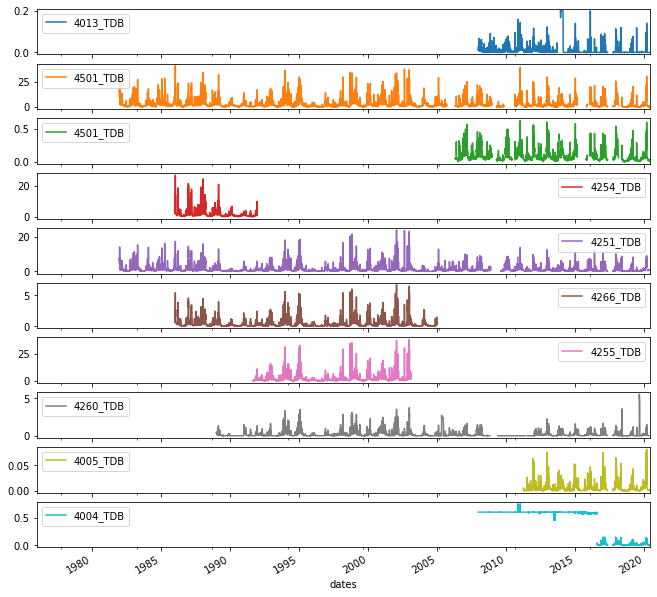

In [294]:
mtpnt.loc[:,mtpnt.columns.str.contains('TDB')].plot(subplots=True, figsize=(11,11));